# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [1]:
#!mkdir cifar10
#!curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
#!tar -xvzf cifar-10-python.tar.gz -C cifar10

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
data = load_CIFAR10(cifar10_dir)
X_train = data['X_train']
y_train = data['Y_train']
X_test = data['X_test']
y_test = data['Y_test']

#X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
print("X_train ", X_train.shape, " X_test ", X_test.shape)

Using cuDNN version 5110 on context None
Mapped name None to device cuda0: GRID K520 (0000:00:03.0)


X_train  (100000, 3, 32, 32)  X_test  (10000, 3, 32, 32)


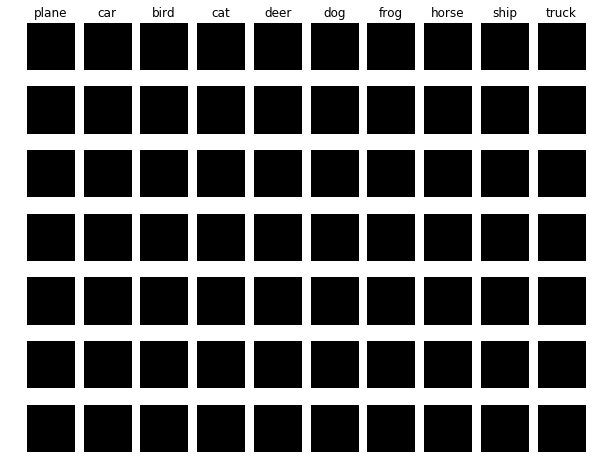

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

5 лет назад сверточные сети были намного менее глубокими, чем сейчас. Возьмем, к примеру, AlexNet (2012) - там было в общей сложности 8 слоев. Эта сверточная сеть давала топ-5 ошибку, т.е. для каждой картинки на выходе было 5 классов и если правильный попал в их число, то предсказание считалось правильным. К совеременным сверточным сетям отностся более глубокие: VGG с 19 слоями, GoogleNet с 22 слоями и ResNet - 152 слоя. 

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

Если создать сразу очень глубокую сеть, она может не учиться. Чтобы это пофиксить, можно к не очень глубокой сети постепенно добавлять слои и доучивать на уже полученных весах.


**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

Думаю, можно использовать уже натренированные сети и файн тьюнинг. Если это не работает, возможно, нужно из маленького датасета генироровать большой добавлением шумов, преобразованием изображением и тому подобное.

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

Сделать из аудиозаписи спектрограмму и работать как с картинкой. Длеать мини-батчи по времени.

In [5]:
import lasagne
from lasagne.layers import *
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.ivector("target Y integer")

### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Have fun :)

#### Модель взята на основе статьи из лекции: http://arxiv.org/abs/1512.03385

In [15]:
def residual_block(net, increase_dim=False):
    input_num_filters = net.output_shape[1]
    if increase_dim:
        stride = (2,2)
        out_num_filters = input_num_filters*2
    else:
        stride = (1,1)
        out_num_filters = input_num_filters
    
    net_ = Conv2DLayer(net, num_filters=out_num_filters, filter_size=(3,3), stride=stride, pad='same', 
                         W=lasagne.init.HeNormal(gain='relu'), flip_filters=False)
    net_ = batch_norm(net_)
    net_ = Conv2DLayer(net_, num_filters=out_num_filters, filter_size=(3,3), stride=(1,1), 
                         nonlinearity=None, pad='same', W=lasagne.init.HeNormal(gain='relu'), flip_filters=False)
    net_ = batch_norm(net_)

    if increase_dim:
        # shortcut 
        identity = ExpressionLayer(net, lambda X: X[:, :, ::2, ::2], lambda s: (s[0], s[1], s[2]//2, s[3]//2))
        padding = PadLayer(identity, [out_num_filters//4,0,0], batch_ndim=1)
        elem = ElemwiseSumLayer([net_, padding])
        block = NonlinearityLayer(elem,nonlinearity=rectify)
    else:
        elem = ElemwiseSumLayer([net_, net])
        block = NonlinearityLayer(elem,nonlinearity=rectify)

    return block

In [16]:
net = InputLayer(shape=(None, 3, 32, 32), input_var=input_X)
net = Conv2DLayer(net, num_filters=16, filter_size=(3,3), pad='same', 
                  W=lasagne.init.HeNormal(gain='relu'), flip_filters=False)
net = batch_norm(net)

for i in range(5):
    net = residual_block(net)

net = residual_block(net, increase_dim=True)
for i in range(1,5):
    net = residual_block(net)

net = residual_block(net, increase_dim=True)
for i in range(1,5):
    net = residual_block(net)

net = GlobalPoolLayer(net)

net = DenseLayer(net, num_units=10, W=lasagne.init.HeNormal(), nonlinearity=softmax)

In [17]:
y_predicted = lasagne.layers.get_output(net)

all_weights = lasagne.layers.get_all_params(net, trainable=True)
print (all_weights)

[W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, b]


In [18]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean() 
all_layers = lasagne.layers.get_all_layers(net)
loss += lasagne.regularization.regularize_layer_params(all_layers, 
                                                       lasagne.regularization.l2) * 1e-4

accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean() 

In [19]:
lr = 0.1
sh_lr = theano.shared(lasagne.utils.floatX(lr))
updates = lasagne.updates.momentum(loss, all_weights, learning_rate=sh_lr, momentum=0.9)

In [20]:
train_fn = theano.function([input_X, target_y], loss, updates=updates)

test_prediction = lasagne.layers.get_output(net, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,target_y).mean()
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_y),
                  dtype=theano.config.floatX)

val_fn = theano.function([input_X, target_y], [test_loss, test_acc])

### Вот и всё, пошли её учить

In [21]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False, augment=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        if augment:
            padded = np.pad(inputs[excerpt],((0,0),(0,0),(4,4),(4,4)),mode='constant')
            random_cropped = np.zeros(inputs[excerpt].shape, dtype=np.float32)
            crops = np.random.random_integers(0,high=8,size=(batchsize,2))
            for r in range(batchsize):
                random_cropped[r,:,:,:] = padded[r,:,crops[r,0]:(crops[r,0]+32),crops[r,1]:(crops[r,1]+32)]
            inp_exc = random_cropped
        else:
            inp_exc = inputs[excerpt]

        yield inp_exc, targets[excerpt]

In [22]:
import time
time.ctime()

'Thu Apr 27 11:27:58 2017'

# Процесс обучения

In [23]:
train_loss_array = []
val_loss_array = []
val_acc_array = []

In [24]:
### import time

num_epochs = 82

for epoch in range(num_epochs):
            # shuffle training data
    train_indices = np.arange(100000)
    np.random.shuffle(train_indices)
    X_train = X_train[train_indices,:,:,:]
    y_train = y_train[train_indices]

    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, 128, shuffle=True, augment=True):
        inputs, targets = batch
        train_err += train_fn(inputs, targets)
        train_batches += 1

    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 500, shuffle=False):
        inputs, targets = batch
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

    train_loss_array.append(train_err / train_batches)
    val_loss_array.append(val_err / val_batches)
    val_acc_array.append(val_acc / val_batches * 100)
    
    # adjust learning rate as in paper
    # 32k and 48k iterations should be roughly equivalent to 41 and 61 epochs
    if (epoch+1) == 41 or (epoch+1) == 61:
        new_lr = sh_lr.get_value() * 0.1
        print("New LR:"+str(new_lr))
        sh_lr.set_value(lasagne.utils.floatX(new_lr))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: DeprecationWarning: This function is deprecated. Please call randint(0, 8 + 1) instead


Epoch 1 of 82 took 210.161s
  training loss:		1.810493
  validation loss:		1.203177
  validation accuracy:		57.66 %
Epoch 2 of 82 took 210.158s
  training loss:		1.196264
  validation loss:		0.909361
  validation accuracy:		69.72 %
Epoch 3 of 82 took 210.150s
  training loss:		0.936636
  validation loss:		0.848096
  validation accuracy:		73.17 %
Epoch 4 of 82 took 210.146s
  training loss:		0.814017
  validation loss:		0.730624
  validation accuracy:		75.85 %
Epoch 5 of 82 took 210.153s
  training loss:		0.741796
  validation loss:		0.604076
  validation accuracy:		80.33 %
Epoch 6 of 82 took 210.140s
  training loss:		0.701765
  validation loss:		0.558032
  validation accuracy:		81.32 %
Epoch 7 of 82 took 210.172s
  training loss:		0.670020
  validation loss:		0.605088
  validation accuracy:		80.61 %
Epoch 8 of 82 took 210.151s
  training loss:		0.655080
  validation loss:		0.744129
  validation accuracy:		76.45 %
Epoch 9 of 82 took 210.140s
  training loss:		0.632365
  validation loss

In [25]:
test_err = 0
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500, shuffle=False):
    inputs, targets = batch
    err, acc = val_fn(inputs, targets)
    test_err += err
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))



Final results:
  test loss:			0.289238
  test accuracy:		92.89 %


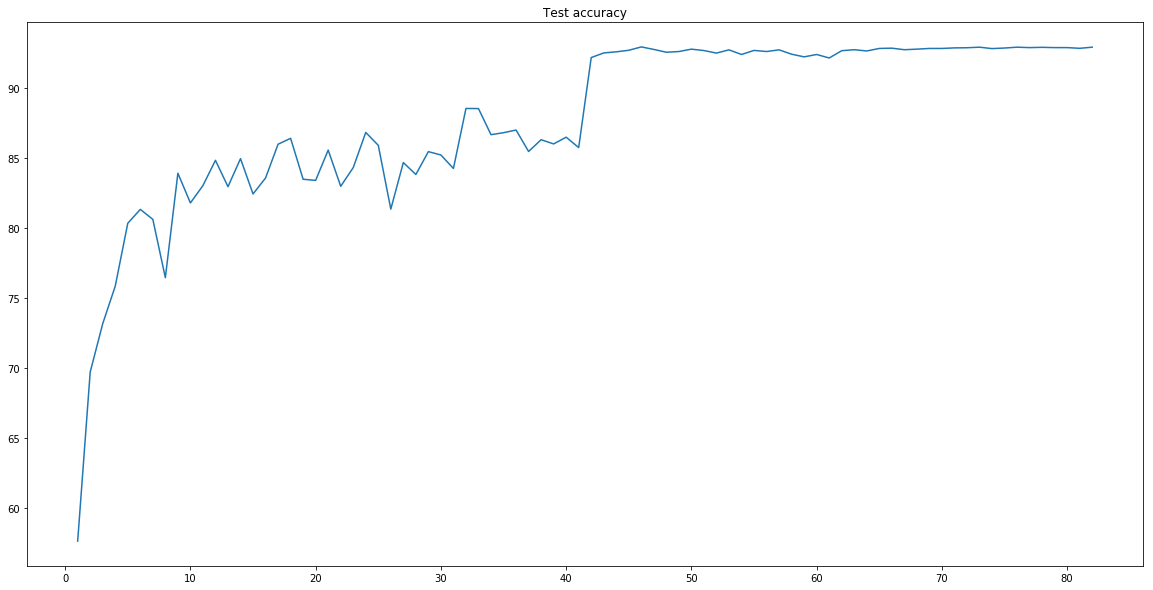

In [26]:
n = np.arange(1, num_epochs + 1)
plt.figure(figsize=(20,10))
plt.plot(n, val_acc_array)
plt.title('Test accuracy')
plt.savefig('plt_accuracy.png')
plt.show()

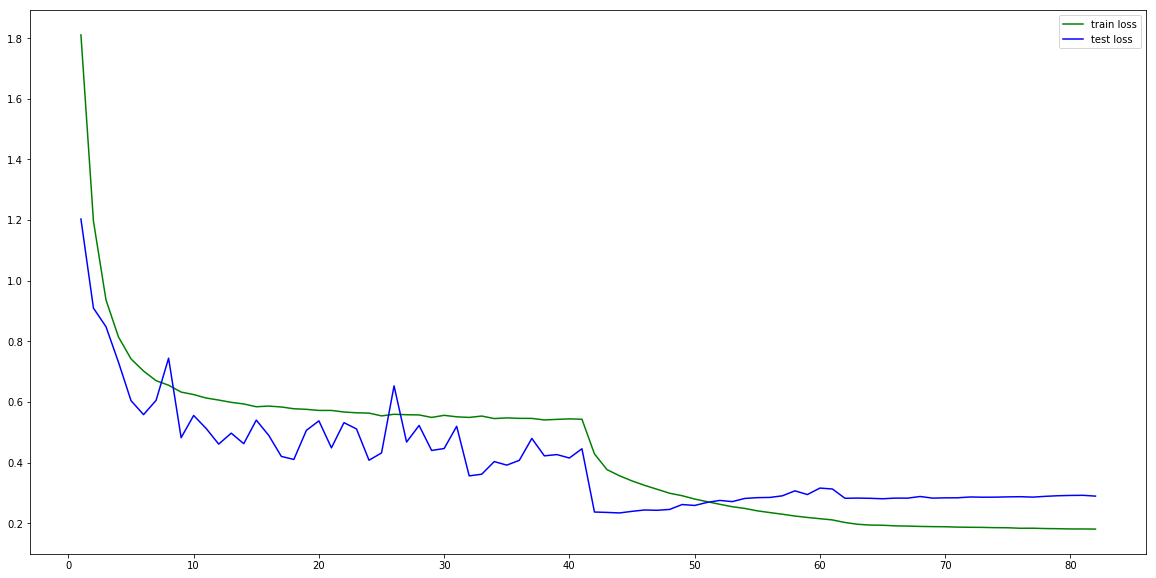

In [27]:
plt.figure(figsize=(20,10))
plt.plot(n, train_loss_array, color='green', label='train loss')
plt.plot(n, val_loss_array, color='blue', label='test loss')
plt.legend()
plt.savefig('plt_loss.png')
plt.show()

## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 